[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cdrc1103/MasterThesis/blob/master/Experiments/MultiClass/BERTForPatents.ipynb)

### Setup Notebook

In [1]:
import tensorflow as tf
import os

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.55.218.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.218.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
%%capture
%matplotlib inline
!pip install wandb
!pip install -qq transformers
!pip install datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data & Parameters



In [4]:
import json
from pathlib import Path
import pandas as pd

RUN_ID = "1.3_BERT1024RES"
BASE_DIR = Path(f"gdrive/MyDrive/Colab Notebooks/Thesis")
RUN_DIR = BASE_DIR / "MultiClass/Runs"

# Load parameters
class Parameter():
  def __init__(self):
    self.__dict__ = {
      "project_name": "thesis_multi-class",
      "train_dataset": "train_RES.csv",
      "test_dataset": "test_RES.csv",
      "embedding_dataset": "bert-for-patents",
      "max_token_length": 30, # number of words/subwords, an instance is truncated to
      "max_tokens": 30000, # vocabulary size
      "embedding_dim": 1024,
      "batch_size": 32,
      "learning_rate": 3e-5,
      "epochs": 3,
      "seed": 1, # random seed for reproducability
      "logging": True, # whether to log to the wandb database (True) or to disk (False)
      "n_classes": 17,
      "in_feature": "abstract", # feature used for training
      "out_feature": "label", # feature to predict
      "sample_weights": False,
      "output_size": 1024, # output size of the language processing layer, i.e. the CNN, GRU etc. layer
      "dropout_rate": 0.1, # for regularization
    }

# Save to disk          
PARAMS = Parameter()
with open(RUN_DIR / f"{RUN_ID}.json", "w") as f:
  json.dump(PARAMS.__dict__, f)

# Read data sets
train_df = pd.read_csv(BASE_DIR / PARAMS.train_dataset, index_col=0)
train_df = train_df.sample(frac=1, random_state=PARAMS.seed)
test_df = pd.read_csv(BASE_DIR / PARAMS.test_dataset, index_col=0)
test_df = test_df.sample(frac=1, random_state=PARAMS.seed)

# Print stats
print(f"Train data set:{len(train_df)} instances")
print(f"Test data set:{len(test_df)} instances")

Train data set:91849 instances
Test data set:22948 instances


## Configure logging

In [5]:
# Logging
import wandb

# log to wandb
if PARAMS.logging:
    !wandb login
    run = wandb.init(project=PARAMS.project_name)
    run.name = RUN_ID
    log_dir = Path(wandb.run.dir)
    wandb.config.update(PARAMS.__dict__)
# log to disk
else:
    log_dir = RUN_DIR

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: cdrc1103 (use `wandb login --relogin` to force relogin)


## Model

In [6]:
""" Dependencies """
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, GRU, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from datasets import Dataset

""" Apply weights to samples """
if PARAMS.sample_weights:
  # Determine class weights to reduce class imbalance
  class_weight = {}
  total_instances = len(train_df)
  class_freqs = train_df[PARAMS.out_feature].value_counts()
  for class_id, freq in zip(class_freqs.index, class_freqs):
      class_weight[class_id] = total_instances / (freq * PARAMS.n_classes)
  sample_weight = np.zeros(len(train_df))
  for i, class_id in enumerate(train_df[PARAMS.out_feature]):
      sample_weight[i] = class_weight[class_id]

""" Configure tokenizer """
config = BertConfig.from_json_file(BASE_DIR/"bert_for_patents_large_config.json")
config.num_labels=PARAMS.n_classes
tokenizer = BertTokenizerFast(BASE_DIR/"bert_for_patents_vocab_39k.txt", config=config)
tokenizer.add_special_tokens({"additional_special_tokens": [f"[{PARAMS.in_feature}]"]})

""" Create TF datasets """
# Add special tokens
train_df[PARAMS.in_feature] = train_df[PARAMS.in_feature].apply(lambda x: f"[{PARAMS.in_feature}] {x}")
test_df[PARAMS.in_feature] = test_df[PARAMS.in_feature].apply(lambda x: f"[{PARAMS.in_feature}] {x}")
# Aggregate features
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenize
def tokenize(batch):
    return tokenizer(batch[PARAMS.in_feature], truncation=True, padding=True, max_length=PARAMS.max_token_length)
train_ds = train_ds.map(tokenize, batched=True, batch_size=PARAMS.batch_size)
test_ds = test_ds.map(tokenize, batched=True, batch_size=PARAMS.batch_size)

# Transform to tensorflow data set 
train_ds.set_format(type='tensorflow', columns=['attention_mask','input_ids', 'label'])
train_features = {x: train_ds[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
train_ds = (train_features, to_categorical(train_ds[PARAMS.out_feature], num_classes=PARAMS.n_classes))
# Whether to add weights to data set
if PARAMS.sample_weights:
  train_ds = train_ds + (sample_weight,)
train_ds = tf.data.Dataset.from_tensor_slices(train_ds).batch(PARAMS.batch_size)
# Transform validation data set
test_ds.set_format(type='tensorflow', columns=['attention_mask','input_ids', 'label'])
test_features = {x: test_ds[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
test_ds = tf.data.Dataset.from_tensor_slices((test_features, to_categorical(test_ds[PARAMS.out_feature], num_classes=PARAMS.n_classes))).batch(PARAMS.batch_size)

""" Define model architecture """
def build_model():
  input_ids = Input(shape=PARAMS.max_token_length, name='input_ids', dtype='int32')
  attention_mask = Input(shape=PARAMS.max_token_length, name='attention_mask', dtype='int32')
  transformer_model = TFBertModel.from_pretrained(BASE_DIR/"pytorch_model.bin", config=config, from_pt=True)
  embedding = transformer_model.layers[0](input_ids, attention_mask=attention_mask)[1]
  dropout = Dropout(PARAMS.dropout_rate)(embedding)
  output = Dense(PARAMS.n_classes, activation='softmax')(dropout)
  return Model(inputs={"input_ids": input_ids, "attention_mask": attention_mask}, outputs=output)

## Training

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from wandb.keras import WandbCallback

""" Transfer to TPU """
with strategy.scope():
  model = build_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate=PARAMS.learning_rate, epsilon=1e-08, clipnorm=1.0)
  loss = CategoricalCrossentropy(from_logits=False)
  metrics = [
    Precision(name='precision'), # tp / (tp+fp)
    CategoricalAccuracy(name='accuracy'), # (tp+tn) / (tp+fp+tn+fn)
    Recall(name='recall') # tp / (tp + fn)
  ]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # train the model
  history = model.fit(
    x=train_ds,
    epochs=PARAMS.epochs,
    verbose=1,
    validation_data=test_ds
    )

pd.DataFrame(history.history).to_csv(log_dir/"history.csv")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 17) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 17) dtype=float32>]


2871/2871 [==============================] - ETA: 0s - loss: 0.7713 - precision: 0.8197 - accuracy: 0.7577 - recall: 0.7034

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 17) dtype=float32>]


2871/2871 [==============================] - 726s 196ms/step - loss: 0.7713 - precision: 0.8197 - accuracy: 0.7577 - recall: 0.7034 - val_loss: 0.7733 - val_precision: 0.7899 - val_accuracy: 0.7543 - val_recall: 0.7204
Epoch 2/3
2871/2871 [==============================] - 448s 156ms/step - loss: 0.4578 - precision: 0.8771 - accuracy: 0.8509 - recall: 0.8269 - val_loss: 0.7719 - val_precision: 0.7985 - val_accuracy: 0.7727 - val_recall: 0.7522
Epoch 3/3
2871/2871 [==============================] - 447s 156ms/step - loss: 0.3518 - precision: 0.9005 - accuracy: 0.8842 - recall: 0.8694 - val_loss: 0.8828 - val_precision: 0.7857 - val_accuracy: 0.7713 - val_recall: 0.7606


In [8]:
from contextlib import redirect_stdout

""" Generate model summary """
print(model.summary())
with open(log_dir/'model_summary.txt', 'w') as file:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: file.write(x + '\n'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 344702976   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           bert[0][1]                   

## Evaluate

In [9]:
# Get predictions on test dataset
with strategy.scope():
  predictions = model.predict(
      x=test_ds,
      verbose=1,
      batch_size=PARAMS.batch_size
  ) # Probability distribution over the labels
np.savetxt(log_dir/"predictions.txt", predictions)

pred_label =np.argmax(predictions, axis=1) # select the prediction with highest probability
true_label = test_df[PARAMS.out_feature].to_numpy() # select the true label from one-hot encoding

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 17) dtype=float32>]


718/718 [==============================] - 38s 43ms/step


In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"]})
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import math

In [11]:
""" Brier score """
def brier(true_label, pred_label, n_classes):
  brier_scores = {}
  for i in range(n_classes):
    row_id = np.where(true_label==i)[0]
    prob = pred_label[row_id, i]
    true = np.ones(len(prob))
    brier_scores[i] = brier_score_loss(true, prob).round(2)
  return brier_scores
brier_scores = brier(true_label, predictions, PARAMS.n_classes)
if PARAMS.logging:
  wandb.log({"brier": brier_scores})
brier_scores

{0: 0.48,
 1: 0.16,
 2: 0.21,
 3: 0.07,
 4: 0.11,
 5: 0.14,
 6: 0.1,
 7: 0.24,
 8: 0.12,
 9: 0.2,
 10: 0.32,
 11: 0.25,
 12: 0.5,
 13: 0.49,
 14: 0.36,
 15: 0.12,
 16: 0.26}

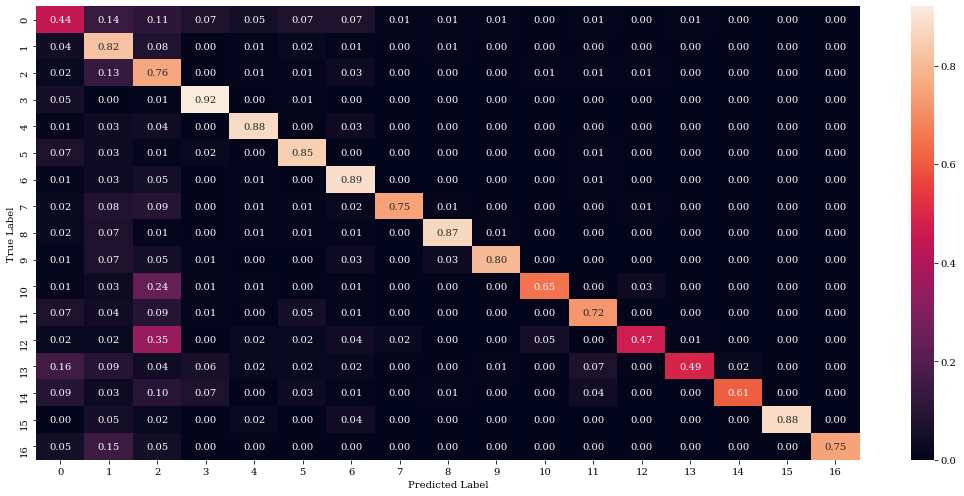

In [12]:
""" Confusion matrix """
def plot_cm(true_label, pred_label, n_classes):
    # compute values
    cm = confusion_matrix(true_label, pred_label, labels=np.arange(0,n_classes))
    # normalize values
    sum_per_label = np.sum(cm, axis=1)
    cm_norm = cm / sum_per_label[:, None]
    cm_norm =np.round(cm_norm, 2)
    # plot
    fig = plt.figure(figsize=(15,7))
    sns.heatmap(cm_norm, annot=True, fmt=".2f")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.plot()
    return fig

fig = plot_cm(true_label, pred_label, PARAMS.n_classes)
fig.savefig(log_dir/"confusion.png", dpi=150)

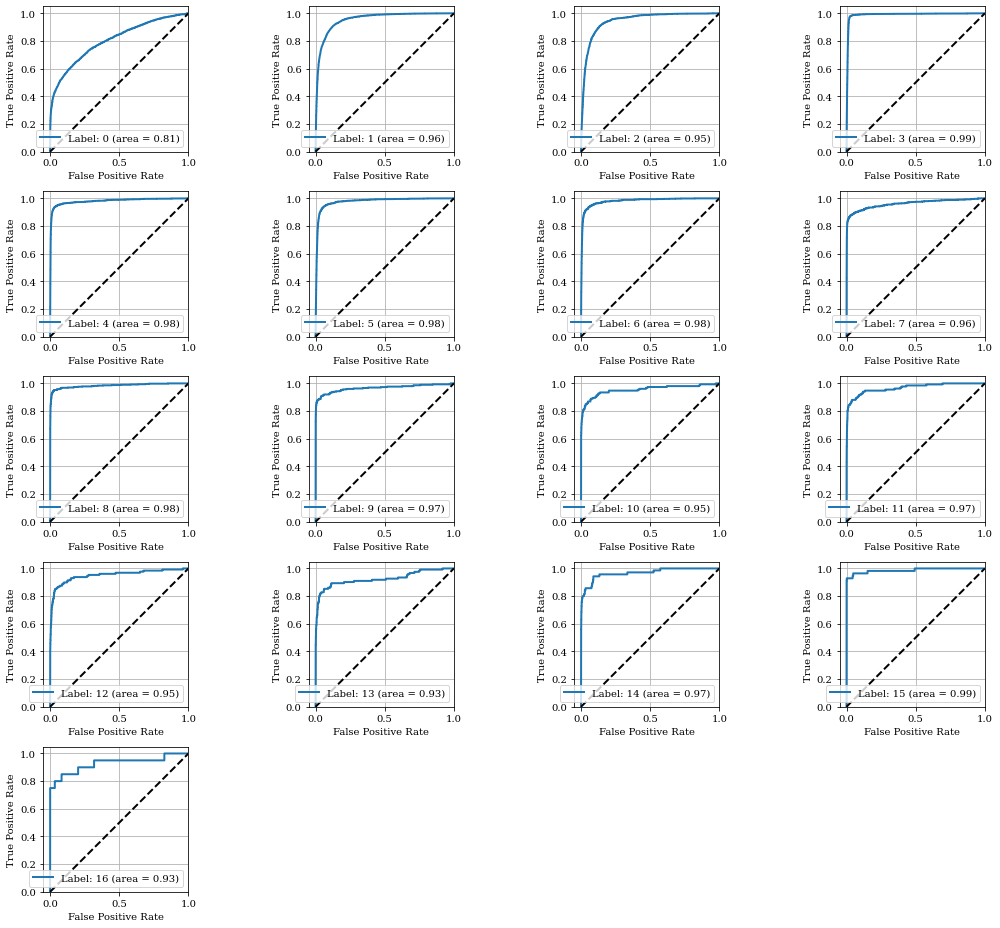

In [13]:
""" Receiver operating characteristic """
def plot_roc(true_label, pred_label, n_classes):
    fig = plt.figure(figsize=(15, 13))
    linewidth = 2
    fpr = {}
    tpr = {}
    roc_auc = {}
    cols = math.floor(math.sqrt(n_classes))
    rows = math.ceil(n_classes / cols)
    
    # calculate class-wise rocs
    for i in range(n_classes):
        row_id = np.where(true_label==i)[0]
        binary_truth = np.zeros(len(true_label))
        binary_truth[row_id] = 1
        fpr[i], tpr[i], _ = roc_curve(binary_truth, pred_label[:,i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.subplot(rows, cols, i+1)
        plt.plot(fpr[i], tpr[i], linewidth=linewidth,
                 label='Label: %i (area = %0.2f)' % (i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='black', lw=linewidth, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.05, 1])
        plt.ylim([0, 1.05])
        plt.grid(True)
        plt.legend(loc='lower right')
        ax = plt.gca()
        ax.set_aspect('equal')
    plt.tight_layout()
    return fig

roc = plot_roc(true_label, predictions, PARAMS.n_classes)
roc.savefig(log_dir/"roc.png", dpi=150)

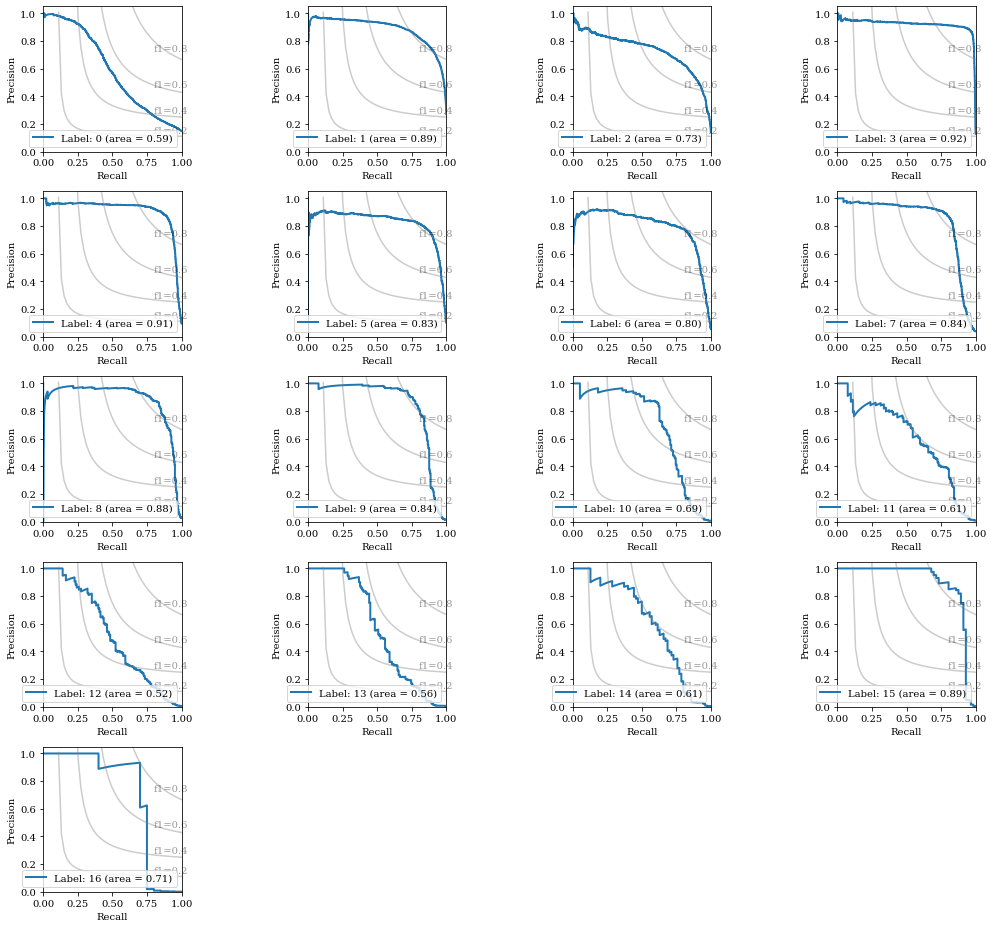

In [14]:
def plot_prec(true_label, pred_label, n_classes):
  precision = dict()
  recall = dict()
  average_precision = dict()
  fig = plt.figure(figsize=(15, 13))
  linewidth = 2
  cols = math.floor(math.sqrt(n_classes))
  rows = math.ceil(n_classes / cols)

  for i in range(n_classes):
      row_id = np.where(true_label==i)[0]
      binary_truth = np.zeros(len(true_label))
      binary_truth[row_id] = 1
      precision[i], recall[i], _ = precision_recall_curve(binary_truth, pred_label[:,i])
      average_precision[i] = average_precision_score(binary_truth, pred_label[:,i])

      plt.subplot(rows, cols, i+1)
      plt.plot(recall[i], precision[i], lw=linewidth, label="Label: %i (area = %0.2f)" %(i, average_precision[i]))
      plt.legend(loc='lower right')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      f_scores = np.linspace(0.2, 0.8, num=4)
      lines = []
      labels = []
      for f_score in f_scores:
          x = np.linspace(0.01, 1)
          y = f_score * x / (2 * x - f_score)
          l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.4)
          plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02), alpha=0.4)
      ax = plt.gca()
      ax.set_aspect('equal')
  plt.tight_layout()

  return fig

prec = plot_prec(true_label, predictions, PARAMS.n_classes)
prec.savefig(log_dir/"prec.png", dpi=150)

In [15]:
""" Classification report """
def create_report(true_label, pred_label, n_classes):
  cls_names =[str(cls) for cls in np.arange(0, n_classes)]
  cls_report = classification_report(true_label, pred_label, target_names=cls_names, output_dict=True)
  return pd.DataFrame(cls_report).round(2).transpose()

cls_report = create_report(true_label, pred_label, PARAMS.n_classes)
cls_report.to_csv(log_dir/"cls_report.csv")
if PARAMS.logging:
  wandb.log({"f1-score": cls_report["f1-score"].to_dict()})
cls_report

,precision,recall,f1-score,support
0,0.68,0.44,0.53,3409.00
1,0.81,0.82,0.81,6152.00
2,0.66,0.76,0.70,3038.00
3,0.90,0.92,0.91,2865.00
4,0.87,0.88,0.88,2146.00
5,0.78,0.85,0.81,1995.00
6,0.63,0.89,0.74,1012.00
7,0.91,0.75,0.82,845.00
8,0.76,0.87,0.81,503.00
9,0.84,0.80,0.82,300.00


## Save loggings

In [16]:
""" Submit results """
if PARAMS.logging:
    run.join()
    run.finish()

_runtime,1919
_timestamp,1622450132
_step,1


_runtime,▁█
_timestamp,▁█
_step,▁█
